In [1]:
# -*- coding: utf-8 -*-
#  File: otus_adv_hw7.ipynb
#  Project: 'OTUS ADV Homework #7'
#  Created by Gennady Matveev (gm@og.ly) on 15-05-2022.

![OTUS.ML.Adv](./header.png)

# **$Homework$** **$7$**
**OTUS Machine Learning Advanced**

# Reinforcement learning: application of Q-Learning algorithm to Lunar Lander environment from OpenAI

**Goals:**   
- Decribe the environment
- Apply the Q-Learning algorithm to find optimal policy
- Evaluate the optimal policy
- Visualize it

**Means:**  
- All meaningful programming will be done in gym

## Lunar lander - description

**Action Space**
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**
There are 8 states: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

**Starting State**
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**
The episode finishes if:
- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport (x coordinate is greater than 1);
- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

When Box2D determines that a body (or group of bodies) has come to rest, the body enters a sleep state which has very little CPU overhead. If a body is awake and collides with a sleeping body, then the sleeping body wakes up. Bodies will also wake up if a joint or contact attached to them is destroyed.

**Source:**
https://www.gymlibrary.ml/environments/box2d/lunar_lander/

#### Important note

- Training time on 10000 episodes takes about an hour. 
- In order to go straight to results of Q-learning you may skip the training phase entirely and   
go straight to experiments section that starts with "[Optionally] load Q_states". 
- All cells preceding "Q-learning algo" still need to be executed.

#### Gym installation 

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import random
import collections
import pickle
from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from IPython import display

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# Append gym location (please change according to your environment)
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages")
import gym

/var/folders/4l/93qkvld10yvfqpg_mxyrn2mh0000gn/T/ipykernel_10191/1976202721.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set lander environment

In [3]:
env = gym.make("LunarLander-v2")
n_episodes = 10000
num_actions = env.action_space.n

### Have a look at the lander

In [4]:
initial_state = env.reset()
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Initial state: {initial_state}")

Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)
Initial state: [-0.00502625  1.4030116  -0.5091148  -0.3515015   0.00583091  0.11532213
  0.          0.        ]


In [5]:
env.reset()
for _ in range(200):
    env.render()
    env.step(env.action_space.sample()) # take a random action
# env.close()

### Helper functions

In [6]:
def discretize_state(state):
    discrete_state = (min(2, max(-2, int((state[0]) / 0.1))), \
                        min(2, max(-2, int((state[1]) / 0.1))), \
                        min(2, max(-2, int((state[2]) / 0.1))), \
                        min(2, max(-2, int((state[3]) / 0.1))), \
                        min(2, max(-2, int((state[4]) / 0.1))), \
                        min(2, max(-2, int((state[5]) / 0.1))), \
                        int(state[6]), \
                        int(state[7]))

    return discrete_state


def epsilon_greedy(q_func, state, eps, env_actions=num_actions):
    prob = np.random.random()

    if prob < eps:
        return random.choice(range(env_actions))
    else:
        qvals = [q_func[state + (action, )] for action in range(env_actions)]
        return np.argmax(qvals)

def greedy(qstates_dict, state, env_actions):
    qvals = [qstates_dict[state + (action, )] for action in range(env_actions)]
    return max(qvals)

def plot_rewards(agent_returns, n_episodes, window):
    num_intervals = int(n_episodes / window)

    print(f"\nLander average reward = {sum(agent_returns) / n_episodes: .2f}")
    l = []
    for j in range(num_intervals):
        l.append(round(np.mean(agent_returns[j * 100 : (j + 1) * 100]), 1))
    plt.figure(figsize=(10,6))
    plt.plot(range(0, n_episodes, window), l, color="b")

    plt.xlabel("Episodes")
    plt.ylabel(f"Reward per {window} episodes")
    plt.title("RL Q-Lander")
    plt.show()


### Q-learning algo

In [7]:
def q_lander(env, n_episodes, gamma, alpha, min_eps, print_freq=500, render_freq=500):
    env.reset()
    q_states = collections.defaultdict(float)
    return_per_ep = [0.0]
    epsilon = 1.0
    num_actions = env.action_space.n
    
    for i in range(n_episodes):
        t = 0
        if (i + 1) % render_freq == 0:
            render = True
        else:
            render = False

        # Initial episode state: 
        curr_state = discretize_state(env.reset())
        
        while True:
            if render:
                env.render()

            # choose action A from S using behaviour policy -> ε-greedy
            action = epsilon_greedy(q_states, curr_state, epsilon, num_actions)

            # Create (S, A) pair
            qstate = curr_state + (action, )

            # Take action A, earn immediate reward R and land into next state S'
            # S --> A --> R --> S'
            observation, reward, done, _ = env.step(action)
            next_state = discretize_state(observation)

            # Policy evaluation
            if not done:
                q_states[qstate] += alpha * (reward + gamma * greedy(q_states, next_state, num_actions) - q_states[qstate]) # (S', A') non terminal state
            else:
                q_states[qstate] += alpha * (reward - q_states[qstate])    # (S', A') terminal state


            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    
                    print(f"Episode {i+1}: Total reward = {return_per_ep[-1]: .1f}")
                    print(f"Episode finished after {t + 1} timesteps")
                    print(f"Total keys in q_states dictionary = {len(q_states)}\n")

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print(f"Last 100 episodes mean reward: {mean_100ep_reward}")

                if epsilon >= min_eps:
                    epsilon *= 0.996

                return_per_ep.append(0.0)

                break

            curr_state = next_state
            t += 1
#     env.close()
    return return_per_ep, q_states


### Run Q-learning

In [8]:
total_rewards, Q_states = q_lander(env, n_episodes=n_episodes, gamma=1, alpha=0.15, min_eps=0.01, render_freq=1000)

Last 100 episodes mean reward: -140.1
Last 100 episodes mean reward: -105.9
Last 100 episodes mean reward: -82.3
Last 100 episodes mean reward: -64.8
Episode 500: Total reward = -224.1
Episode finished after 255 timesteps
Total keys in q_states dictionary = 12896

Last 100 episodes mean reward: -50.8
Last 100 episodes mean reward: -44.0
Last 100 episodes mean reward: -83.6
Last 100 episodes mean reward: -90.5
Last 100 episodes mean reward: -88.7
Episode 1000: Total reward = -84.3
Episode finished after 385 timesteps
Total keys in q_states dictionary = 19600

Last 100 episodes mean reward: -70.3
Last 100 episodes mean reward: -66.2
Last 100 episodes mean reward: -41.8
Last 100 episodes mean reward: -32.7
Last 100 episodes mean reward: -17.7
Episode 1500: Total reward = -55.4
Episode finished after 193 timesteps
Total keys in q_states dictionary = 26128

Last 100 episodes mean reward: -63.0
Last 100 episodes mean reward: -18.4
Last 100 episodes mean reward: -14.2
Last 100 episodes mean r

### Save Q

In [9]:
with open("./Q.pickle","wb") as f:
    pickle.dump(Q_states, f)

### Plot learning results


Lander average reward =  73.04


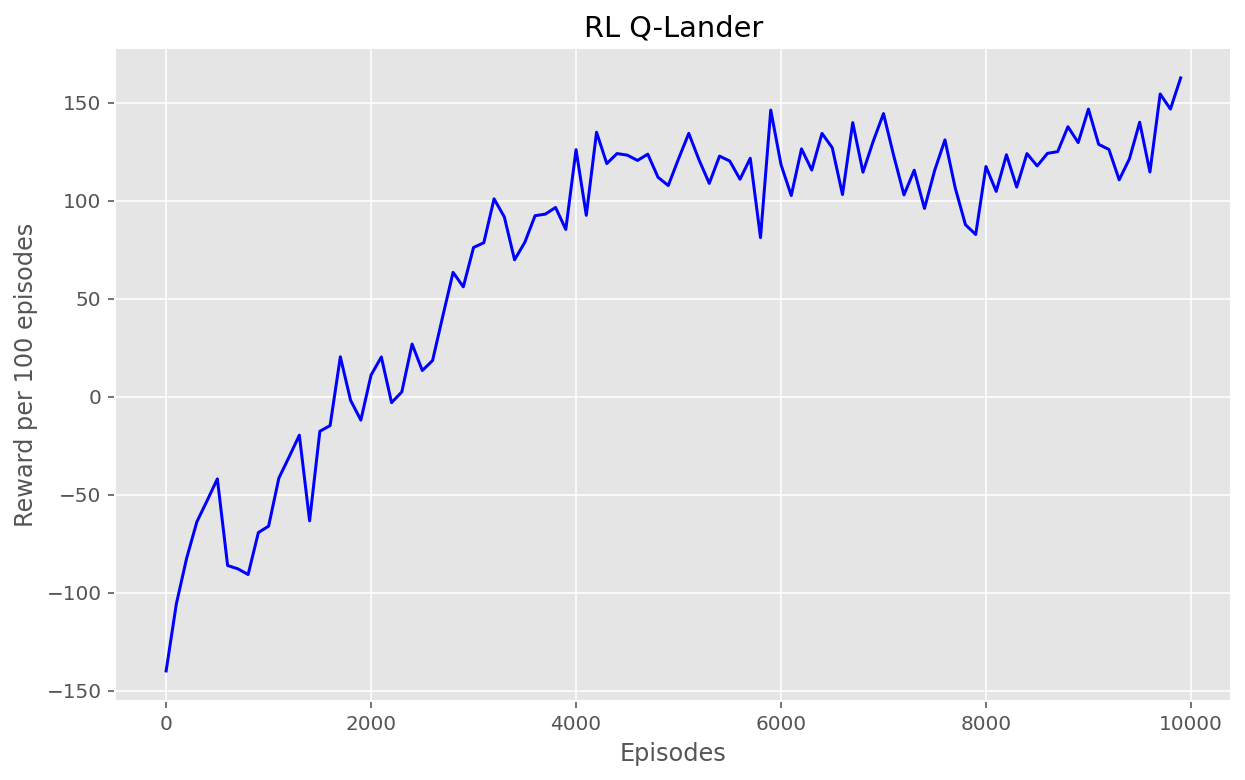

In [10]:
plot_rewards(agent_returns=total_rewards, n_episodes=n_episodes, window=100)

### [Optionally] load Q_states

In [11]:
with open("./Q.pickle", "rb") as f:
    Q_states = pickle.load(f)

### Run experiments with learned Q

In [12]:
def conduct_experiments_q(q_states, n_episodes=10, epsilon= 0.00001):
    
    num_steps, total_reward = [], []
    for n in tqdm(range(n_episodes)): #, ncols="60")
        curr_state = discretize_state(env.reset())
        next_state = curr_state
        num_steps.append(0)
        total_reward.append(0)
        
        while True:        
            action = epsilon_greedy(q_states, next_state, epsilon, num_actions) #curr_state
            observation, reward, done, _ = env.step(action)
            next_state = discretize_state(observation)
            total_reward[-1] += reward
            num_steps[-1] += 1
            if done:
                break
                
    return total_reward, num_steps

In [13]:
env = gym.make("LunarLander-v2")

### Conduct experiments

In [14]:
res = conduct_experiments_q(q_states=Q_states, n_episodes=n_episodes)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Evaluate results


Lander average reward =  155.70


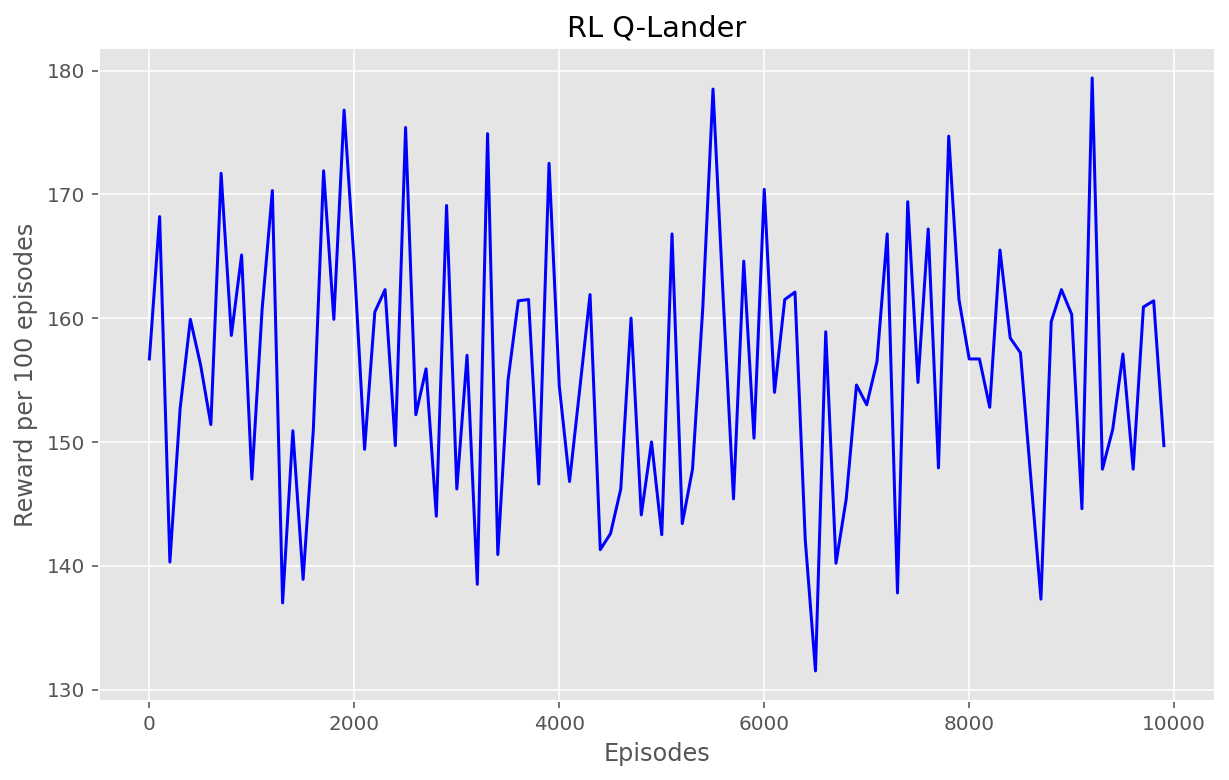

In [15]:
plot_rewards(agent_returns=res[0], n_episodes=n_episodes, window=100)

In [16]:
print(f"Mean reward: {np.mean(res[0]): .1f}")
print(f"Mean reward STD: {np.std(res[0]): .1f}")
print(f"Mean number of timesteps: {np.mean(res[1]): .1f}")
print(f"Success rate: {sum([res[0][i]>=200 for i in range(len(res[0]))])*100/len(res[0])}%")

Mean reward:  155.7
Mean reward STD:  111.6
Mean number of timesteps:  483.6
Success rate: 54.17%


### Visualize an experiment with optimal strategy

In [17]:
total_reward = 0
curr_state = discretize_state(env.reset())
next_state = curr_state
                
while True:
    env.render()
    action = epsilon_greedy(Q_states, next_state, eps=0.0001, env_actions=num_actions) #curr_state
    observation, reward, done, _ = env.step(action)
    next_state = discretize_state(observation)
    total_reward += reward

    if done:
        break
if total_reward >= 200:
    print("Success!")
else:
    print("Opps! Maybe next time...")

Success!


![OTUS.ML.Adv](./footer.png)